# Probablistic Approach to Modelling

Lets start with something we are sure about. We know that when we train a model with dataset D we try to minimize some parameter suppose E. So if we write it in equation form, this becomes
$$
\hat E = \argmin_{E} L(E)
$$
Where, L(E) is a loss function of any form.

## Maximum Likelihood estimation (MLE)

If we totally depend on the data and assume it to be bias free. We talk about MLE estimates. So if we say this statement mathematically, this means we belive that data with the labels are probablistically correct. So we give high probablilty to the data. So our equation becomes
$$
\hat E = \argmax_{E} p(D|E)  
$$
If we have total n datapoints with x input and y output independent of each other. We can represent it as,
$$
p(D|E) = \prod_{i=1}^{n} p(y_{n}|x_{n},E)
$$
Now if we take log of the above function we get log of the likelihood
$$
LogLikelihood(E)  \:\mathbb{:=}\: \log p(D|E) \:\mathbb{:=}\: \sum_{n=1}^{N} \log p(y_{n}|x_{n},E)
$$
So MLE becomes
$$
\hat E = \argmax_{E}\sum_{n=1}^{N} \log p(y_{n}|x_{n},E)
$$
This can also be written as Negative Log Likelihood (NLL)
$$
NegativeLogLikelihood(E) \:\mathbb{:=}\: -\log p(D|E) \:\mathbb{:=}\: -\sum_{n=1}^{N} \log p(y_{n}|x_{n},E)
$$
So finally MLE can be defined as
$$
\hat E = \argmin_{E}-\sum_{n=1}^{N} \log p(y_{n}|x_{n},E)
$$
## KL Divergence

It is a standard way to find dissimilarity between probability distributions p and q where it is defined as below
$$
D_{\mathbb{KL}}(p||q) = \sum_{y}^{}p(y)\log\dfrac{p(y)}{q(y)} = \sum_{y}^{}p(y)\log p(y) - \sum_{y}^{}p(y)\log q(y)
$$
Where the 1st term is entropy of p and 2nd term is cross-entropy of p and q. If we define 
$$
q(y) = p(y|E),  p(y) = p_{D}(y) \qquad\qquad
D_{\mathbb{KL}}(p||q) = \sum_{y}^{}p_{D}(y)\log p_{D}(y) - p_{D}(y)\log q(y)
$$
Here,
$$
D_{\mathbb{KL}}(p||q) = -\mathbb{H}(p_{D}) - \dfrac{1}{N} \sum_{n=1}^{N} \log p(y_{n}|E) 
$$
$$
D_{\mathbb{KL}}(p||q) = const + NLL(E)
$$
So from the above equation we can say that minimizing KL is equivalent to minimizing NLL which is MLE estimate. We even use KL loss function libraries to define loss in models. We can generalize this to defining Expected KL.

Now this can defined for multiple distibutions like Bernouli, Categorical, Gaussian(univariate & multivariate)

## Probablistic Generative modelling

In the current analysis we use Categorical distribution over MINIST Dataset beacuse we have 10 kinds of distibution. We also use Bernouli distribution over each feature. By feature I mean total no. of pixels in 1 image. Since there are 28x28 = 784 pixels, so we have 784 features of binary type. Since features are of binary type we use Bernouli distribution.

So based on the above explaination our model distribution looks like,

`D.MixtureSameFamily(D.Categorical(mean),D.Independent(D.Bernoulli(covariance), reinterpreted_batch_ndims=1))`

### Model used

I have used Adam to train this distribution by minimizing the NLL, which is defined by code as show below
`model_prob = current_m.log_prob(data)` 

and loss funtion is defined as `-sum(model_prob)/data.shape[0]`




In [1]:
from datetime import datetime

import torch
import torchvision
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import torch.distributions as D
from torch.utils.tensorboard import SummaryWriter
import torch.utils.data as data_util
import matplotlib.pyplot as plt
from IPython import display
from collections import Counter

In [2]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

training_data = datasets.MNIST(root="../data/MINST", download=True, train=True, transform=transform)
validation_data = datasets.MNIST(root="../data/MINST", download=True, train=False, transform=transform)

train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=100, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=100, shuffle=False)

In [3]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()
    
class Animator:
    """For plotting data in animation."""

    def __init__(
        self,
        xlabel=None,
        ylabel=None,
        legend=None,
        xlim=None,
        ylim=None,
        xscale="linear",
        yscale="linear",
        fmts=("-", "m--", "g-.", "r:"),
        nrows=1,
        ncols=1,
        figsize=(3.5, 2.5),
    ):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        display.set_matplotlib_formats("svg")
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [
                self.axes,
            ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for i,(x, y) in enumerate(zip(self.X, self.Y)):
            if y:
                if i==0:
                    self.axes[0].plot(x, y, self.fmts[0])
                else:
                    self.axes[0].plot(x, y, self.fmts[1])
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


In [4]:
softmax = nn.Softmax(dim=0)
sigmoid = nn.Sigmoid()

class MNISTModel(nn.Module):

    def __init__(self, total_class = 12, input_shape = 28*28):
        super(MNISTModel, self).__init__()
        random_uniform_val = torch.rand(total_class)
        self.mean = nn.Parameter(random_uniform_val/random_uniform_val.sum())
        self.covariance = nn.Parameter(torch.special.logit(torch.full((total_class,input_shape),1/total_class)))
        
    def forward(self,data):
        current_m = self.update(softmax(self.mean), sigmoid(self.covariance))
        model_prob = current_m.log_prob(data)
        return -sum(model_prob)/data.shape[0]
    
    def update(self,mean,covariance):
        return D.MixtureSameFamily(D.Categorical(mean),D.Independent(D.Bernoulli(covariance), reinterpreted_batch_ndims=1))

model = MNISTModel()

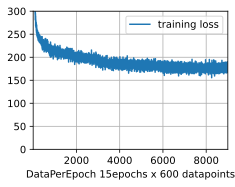

In [5]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
past_steps = 50
def train_one_epoch(animator,epoch):
    last_loss = 0.
    for i, data in enumerate(train_dataloader):
        inputs, _ = data
        batch_size = inputs.shape[0]
        inputs = torch.reshape(inputs,(batch_size,28*28))
        inputs = torch.where(inputs > 0, 1.0, 0.0)
        optimizer.zero_grad()
        output = model(inputs)
        output.backward()
        optimizer.step()
        animator.add(epoch + (i + 1), (output.item(),None)) 
    return last_loss

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/MNIST_{}'.format(timestamp))
EPOCHS = 15
animator = Animator(
        xlabel=f'DataPerEpoch {EPOCHS}epochs x {len(train_dataloader)} datapoints', xlim=[1, EPOCHS*len(train_dataloader)], ylim=[0, 300], legend=["training loss"]
    )
for epoch in range(EPOCHS):
    model.train(True)
    avg_loss = train_one_epoch(animator,epoch*len(train_dataloader))

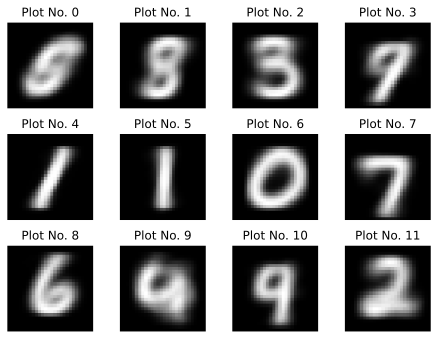

In [6]:
images = sigmoid(list(model.parameters())[1].detach())
fig, axes = plt.subplots(3, 4)
i = 0
for image,ax in zip(images,axes.flatten()):
    image = image.reshape(28,28)
    ax.imshow(image, cmap='gray')
    ax.set_title(f'Plot No. {i}')
    ax.axis("off")
    i = i+1
fig.tight_layout(pad=1.0)
plt.show()

## Analysis

Here I had kept the no of classfication types as 12 instead of 10 to see most varitations in the data. The whole training process is self-supervised without any labels provided to the model and you can see the output taking shape with 15 epochs and 600 data points. Since We had very little data points it becomes harder to train these kind of models.

## References

Here the code used is modified from 


https://github.com/probml/pyprobml



I have studied Probablistic Machine Learning By Kevin P. Murphy and written everything as per my understanding.